In [1]:
%matplotlib inline
import torch
import numpy as np
# import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib
import torch.nn.functional as F
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Import Data 

In [3]:
# geo = torch.load('../sample_data/geo+16.pt')
# mask = torch.load('../sample_data/mask+16.pt')
# # assert geo.shape == (5, 5000)
# # assert mask.shape == (5000, 1), mask.shape

# x_coord, y_coord = geo[0, :], geo[1, :]
# exact_u, exact_v, exact_p = geo[2, :], geo[3, :], geo[4, :]

# x_coord = x_coord#.detach().numpy()
# y_coord = y_coord#.detach().numpy()

# exact_u = exact_u#.detach().numpy()
# exact_v = exact_v#.detach().numpy()
# exact_p = exact_p#.detach().numpy()

FileNotFoundError: [Errno 2] No such file or directory: '../sample_data/mask+16.pt'

In [69]:
mask = torch.tensor(mask, dtype=torch.bool).flatten()
mask.shape
mask

tensor([ True,  True,  True,  ..., False, False, False])

In [79]:
geo.shape

torch.Size([5, 36000])

In [70]:
x_train_all = x_coord.view(-1, 1).to(device)
y_train_all = y_coord.view(-1, 1).to(device)

u_train_all = exact_u.view(-1, 1).to(device)
v_train_all = exact_v.view(-1, 1).to(device)
p_train_all = exact_p.view(-1, 1).to(device)

In [71]:
x_train = x_coord.view(-1, 1).to(device)[mask, :]
y_train = y_coord.view(-1, 1).to(device)[mask, :]

u_train = exact_u.view(-1, 1).to(device)[mask, :]
v_train = exact_v.view(-1, 1).to(device)[mask, :]
p_train = exact_p.view(-1, 1).to(device)[mask, :]

In [148]:
collocation_points = torch.load('../sample_data/u+collocation_points.pt')
bc_points = torch.load('../sample_data/u+boundary_points.pt')

x_train = collocation_points[0, :].view(-1, 1).to(device)
y_train = collocation_points[1, :].view(-1, 1).to(device)

u_train = collocation_points[2, :].view(-1, 1).to(device)
v_train = collocation_points[3, :].view(-1, 1).to(device)
p_train = collocation_points[4, :].view(-1, 1).to(device)


x_train_bc = bc_points[0, :].view(-1, 1).to(device)
y_train_bc = bc_points[1, :].view(-1, 1).to(device)

u_train_bc = bc_points[2, :].view(-1, 1).to(device)
v_train_bc = bc_points[3, :].view(-1, 1).to(device)
p_train_bc = bc_points[4, :].view(-1, 1).to(device)

In [149]:
print ("#collocation points:" , v_train.shape[0], "#boundary points:", v_train_bc.shape[0], "p_train_bc.max()=", p_train_bc.max())


#collocation points: 5589 #boundary points: 610 p_train_bc.max()= tensor(0.0977, device='cuda:0')


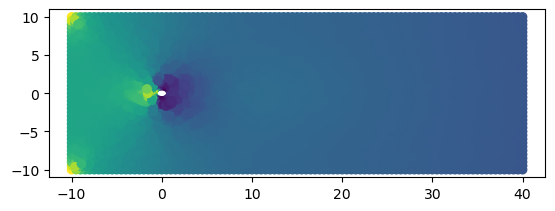

In [150]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
# ax2 = fig.add_subplot(2,1,2)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=p_train.cpu().detach().numpy(), cmap="viridis")
# ax2.plot(range(10))

plt.show()

### Format data

### Model

In [152]:
class PINN():


    def __init__(self, x, y,  u, v, p, bc_x, bc_y,  bc_u, bc_v, bc_p ):
        
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
        self.bc_x = torch.tensor(bc_x, dtype=torch.float32, requires_grad=True)
        self.bc_y = torch.tensor(bc_y, dtype=torch.float32, requires_grad=True)
        
        
#         self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
        self.exact_u = torch.tensor(u, dtype=torch.float32, requires_grad=True)
        self.exact_v = torch.tensor(v, dtype=torch.float32, requires_grad=True)
        self.exact_p = torch.tensor(p, dtype=torch.float32, requires_grad=True)

        self.bc_exact_u = torch.tensor(bc_u, dtype=torch.float32, requires_grad=True)
        self.bc_exact_v = torch.tensor(bc_v, dtype=torch.float32, requires_grad=True)
        self.bc_exact_p = torch.tensor(bc_p, dtype=torch.float32, requires_grad=True)
        
        self.grouth_truth = torch.cat((u, v, p), 1)
        self.bc_grouth_truth = torch.cat((bc_u, bc_v, bc_p), 1)
        


        self.null = torch.zeros_like(self.x)

        self.neuralnet()

        #self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr= 0.01, max_iter= 10000, max_eval= 5000, history_size= 50, line_search_fn= 'strong_wolfe', tolerance_change= 0.5* np.finfo(float).eps, tolerance_grad= 1e-05)
        # self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=0.1, max_iter=200000, max_eval=50000,
        #                                    history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
        #                                    line_search_fn="strong_wolfe")
        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr= 0.5, max_iter= 5_000)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.001)
        
        self.mse = torch.nn.MSELoss()
        self.loss = 0
        self.best_loss = 1000
        self.iter = 0
        num_measure_data = 5000
        all_indices = torch.randperm(self.exact_u.size(0))
        self.indices = all_indices[:num_measure_data]

    def neuralnet(self):
        # hidden_size=20
        # self.net = torch.nn.Sequential(
        #     torch.nn.Linear(2, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh(),
        #     torch.nn.Linear(hidden_size, 3),  torch.nn.Tanh()).to(device)

        self.net = torch.nn.Sequential()
        dimension = 2
        hidden_layers = 20
        layer_neurons = 32
        layer_mat = [dimension] + hidden_layers * [layer_neurons] + [3]
        layer_num = len(layer_mat) - 1 
        for i in range(0, layer_num - 1):
            self.net.add_module(str(i) + "linear", nn.Linear(layer_mat[i], layer_mat[i + 1]))
            self.net.add_module(str(i) + "Act", nn.Tanh())  
        self.net.add_module(str(i) + "linear-last", nn.Linear(layer_mat[i+1], layer_mat[i + 2]))     
        # self.net.add_module(str(i) + "act-last", nn.Tanh())       
        self.net.to(device)
        
    def forward(self, x, y):
        X = torch.cat([x, y], 1).requires_grad_(True)
        result = self.net(X)
        u, v, p = result[:, 0:1], result[:, 1:2], result[:, 2:3]
        return u, v , p
    
    def navier_stokes(self, x, y):
        lambda_1, lambda_2 = 1., 0.02
        # result = self.net(torch.cat([x, y], 1))
        # psi, p = result[:, 0:1], result[:, 1:2]
        # u = torch.autograd.grad(psi, y, torch.ones_like(x), create_graph=True, )[0]
        # v = torch.autograd.grad(psi, x, torch.ones_like(y), create_graph=True, )[0]

        u, v, p = self.forward(x, y)
        p_x = torch.autograd.grad(p, x, torch.ones_like(x), create_graph=True,)[0]
        p_y = torch.autograd.grad(p, y, torch.ones_like(y), create_graph=True, )[0]

#         u_t = torch.autograd.grad(u, t, torch.ones_like(t), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True,)[0]
        u_y = torch.autograd.grad(u, y, torch.ones_like(y), create_graph=True, )[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x), create_graph=True, )[0]
        u_yy = torch.autograd.grad(u_y, y, torch.ones_like(y), create_graph=True, )[0]

#         v_t = torch.autograd.grad(v, t, torch.ones_like(t), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(x), create_graph=True, )[0]
        v_y = torch.autograd.grad(v, y, torch.ones_like(y), create_graph=True, )[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(x), create_graph=True,)[0]
        v_yy = torch.autograd.grad(v_y, y, torch.ones_like(y), create_graph=True,)[0]

        f_u = lambda_1 * (u*u_x + v*u_y) + p_x - lambda_2 * (u_xx + u_yy)
        f_v = lambda_1 * (u*v_x + v*v_y) + p_y - lambda_2 * (v_xx + v_yy)
        f_mass = u_x + v_y

        return u, v, p, f_u, f_v, f_mass, 
    
    def closure(self):
        self.optimizer.zero_grad()
        
        # collocation points only
        predicted_u, predicted_v, predicted_p, f_u_pred, f_v_pred, f_mass = self.navier_stokes(self.x, self.y)
        loss_f_u = self.mse(f_u_pred, torch.zeros_like(f_u_pred))
        loss_f_v = self.mse(f_v_pred, torch.zeros_like(f_v_pred))
        loss_f_mass = self.mse(f_mass, torch.zeros_like(f_mass))
        pde_loss =  loss_f_mass + loss_f_u + loss_f_v  

        
        # bc only
        bc_u, bc_v, bc_p  = self.forward(self.bc_x, self.bc_y)
        bc_mse_loss = F.mse_loss(torch.cat([bc_u, bc_v, bc_p], dim=1), self.bc_grouth_truth)

        # only for logging purpose., not included in the loss function!
        collocation_points_mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), self.grouth_truth)
        measurement_data_loss = F.mse_loss(predicted_u[self.indices, :], self.exact_u[self.indices, :]) + \
              F.mse_loss(predicted_v[self.indices, :], self.exact_v[self.indices, :]) + \
                F.mse_loss(predicted_p[self.indices, :], self.exact_p[self.indices, :])
        

        self.loss =  pde_loss + bc_mse_loss #+ measurement_data_loss #+ pde_loss + bc_mse_loss 
        self.loss.backward()
        self.optimizer.step()

        self.iter += 1
        if not self.iter % 1:            
            print("Iteration: {:} Total Loss: {:.6e},  PDE Loss: {:.6e}  Collocation Points/MSE Loss: {:.6f}, BC/MSE loss: {:.6f}".format(self.iter, self.loss, pde_loss, collocation_points_mse_loss, bc_mse_loss))

        return self.loss

    def train_nn(self):
        
        self.net.train()
        current_loss = self.closure()
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            torch.save(self.net.state_dict(), f'pinn_navier_stokes+best.pth')

In [153]:
pinn_navier_stokes = PINN(x_train, y_train, u_train, v_train, p_train,
                          x_train_bc, y_train_bc, u_train_bc, v_train_bc, p_train_bc)

/tmp/ipykernel_3652404/2410958012.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bc_x = torch.tensor(bc_x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:9: UserWarning: To copy construct from a tens

In [154]:
pinn_navier_stokes.net

Sequential(
  (0linear): Linear(in_features=2, out_features=32, bias=True)
  (0Act): Tanh()
  (1linear): Linear(in_features=32, out_features=32, bias=True)
  (1Act): Tanh()
  (2linear): Linear(in_features=32, out_features=32, bias=True)
  (2Act): Tanh()
  (3linear): Linear(in_features=32, out_features=32, bias=True)
  (3Act): Tanh()
  (4linear): Linear(in_features=32, out_features=32, bias=True)
  (4Act): Tanh()
  (5linear): Linear(in_features=32, out_features=32, bias=True)
  (5Act): Tanh()
  (6linear): Linear(in_features=32, out_features=32, bias=True)
  (6Act): Tanh()
  (7linear): Linear(in_features=32, out_features=32, bias=True)
  (7Act): Tanh()
  (8linear): Linear(in_features=32, out_features=32, bias=True)
  (8Act): Tanh()
  (9linear): Linear(in_features=32, out_features=32, bias=True)
  (9Act): Tanh()
  (10linear): Linear(in_features=32, out_features=32, bias=True)
  (10Act): Tanh()
  (11linear): Linear(in_features=32, out_features=32, bias=True)
  (11Act): Tanh()
  (12linear):

In [168]:
pinn_navier_stokes.optimizer=torch.optim.Adam(pinn_navier_stokes.net.parameters(), lr=0.0005)

In [177]:
N_train = 30000
for _ in range(N_train):
    pinn_navier_stokes.train_nn()

Iteration: 17270 Total Loss: 1.759073e-04,  PDE Loss: 3.820000e-05  Collocation Points/MSE Loss: 0.000810, BC/MSE loss: 0.000138
Iteration: 17271 Total Loss: 1.763575e-03,  PDE Loss: 1.150427e-04  Collocation Points/MSE Loss: 0.001055, BC/MSE loss: 0.001649
Iteration: 17272 Total Loss: 3.443581e-04,  PDE Loss: 5.310877e-05  Collocation Points/MSE Loss: 0.001181, BC/MSE loss: 0.000291
Iteration: 17273 Total Loss: 3.484360e-04,  PDE Loss: 6.475918e-05  Collocation Points/MSE Loss: 0.001703, BC/MSE loss: 0.000284
Iteration: 17274 Total Loss: 6.443379e-04,  PDE Loss: 1.042733e-04  Collocation Points/MSE Loss: 0.002196, BC/MSE loss: 0.000540
Iteration: 17275 Total Loss: 6.756101e-04,  PDE Loss: 1.141926e-04  Collocation Points/MSE Loss: 0.002489, BC/MSE loss: 0.000561
Iteration: 17276 Total Loss: 5.490889e-04,  PDE Loss: 1.006137e-04  Collocation Points/MSE Loss: 0.002594, BC/MSE loss: 0.000448
Iteration: 17277 Total Loss: 5.177372e-04,  PDE Loss: 1.045567e-04  Collocation Points/MSE Loss: 

KeyboardInterrupt: 

In [ ]:
# LBFGS Training
pinn_navier_stokes.train_nn()

In [178]:
pinn = PINN(x_train, y_train,   u_train, v_train, p_train, x_train_bc, y_train_bc,   u_train_bc, v_train_bc, p_train_bc)
pinn.net.load_state_dict(torch.load(f'pinn_navier_stokes+best.pth'))
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
predicted_u, predicted_v, predicted_p, _, _, _,  = pinn.navier_stokes(x_train, y_train)
mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), torch.cat((u_train, v_train, p_train), 1))
print("MSE Loss: {:.6f}".format(mse_loss))

/tmp/ipykernel_3652404/2410958012.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bc_x = torch.tensor(bc_x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:9: UserWarning: To copy construct from a tens

RuntimeError: PytorchStreamReader failed locating file data/4: file not found

In [186]:
case_id = "0001"
torch.save(pinn_navier_stokes.net.state_dict(), f'pinn_navier_stokes+{case_id}.pth')
#pinn = PINN(x_train, y_train,x_train_bc, y_train_bc,  u_train_bc, v_train_bc, p_train_bc)#PINN(x_train, y_train,  u_train, v_train, p_train)
pinn = PINN(x_train, y_train,   u_train, v_train, p_train, x_train_bc, y_train_bc,   u_train_bc, v_train_bc, p_train_bc)
pinn.net.load_state_dict(torch.load(f'pinn_navier_stokes+{case_id}.pth'))
pinn.net.eval()
print ("Load done!")

Load done!


/tmp/ipykernel_3652404/2410958012.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bc_x = torch.tensor(bc_x, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/2410958012.py:9: UserWarning: To copy construct from a tens

In [180]:
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)


predicted_u, predicted_v, predicted_p, _, _, _,  = pinn.navier_stokes(x_train, y_train)
mse_loss = torch.nn.functional.mse_loss(torch.cat([predicted_u, predicted_v, predicted_p], dim=1), torch.cat((u_train, v_train, p_train), 1))
print("MSE Loss: {:.6f}".format(mse_loss))
# print (predicted_p)
# print (p_train)
# print (torch.nn.functional.mse_loss(predicted_p, p_train))

MSE Loss: 0.000363


/tmp/ipykernel_3652404/4203831705.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
/tmp/ipykernel_3652404/4203831705.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)


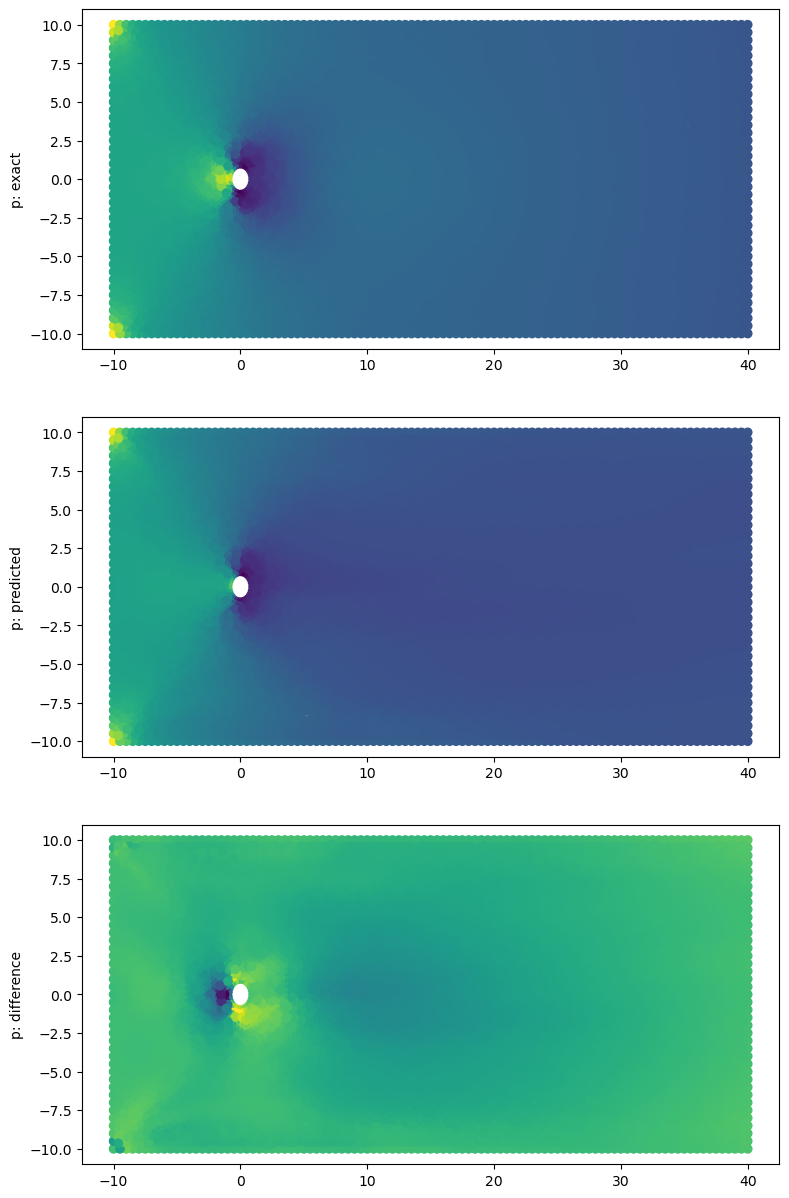

In [181]:
fig = plt.figure(figsize=(9, 15))
ax1 = fig.add_subplot(3,1,1, adjustable='box', )
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=p_train.cpu().detach().numpy()[:74152], cmap="viridis")
ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_p.cpu().detach().numpy(), cmap="viridis")
ax3.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=(predicted_p-p_train).cpu().detach().numpy(), cmap="viridis")

# plt.xlabel('x')
ax1.set_ylabel('p: exact')
ax2.set_ylabel('p: predicted')
ax3.set_ylabel('p: difference')
plt.show()

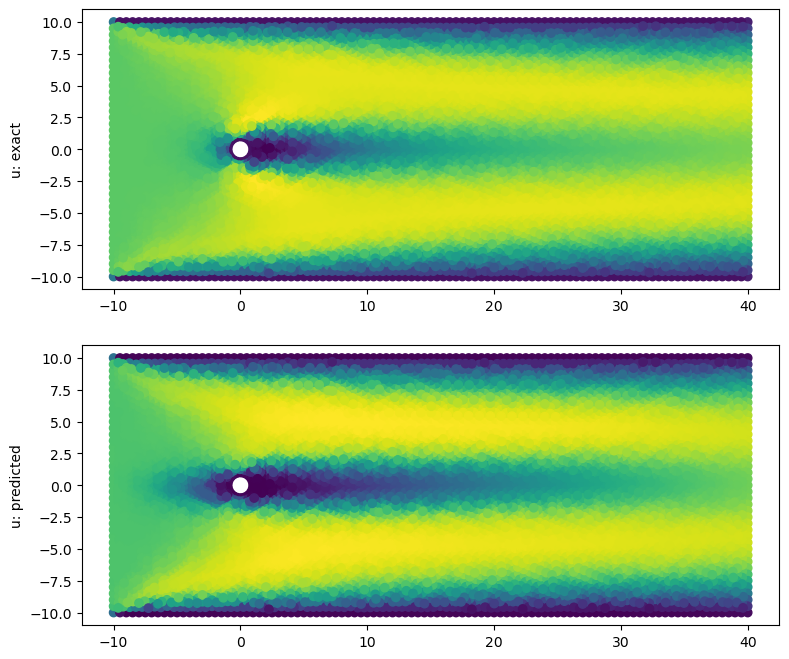

In [184]:
fig = plt.figure(figsize=(9, 8))
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
ax2 = fig.add_subplot(2,1,2)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=u_train.cpu()[:74152], cmap="viridis", label="Exact")
ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_u.cpu().detach().numpy(), cmap="viridis", label="Predicted")
ax1.set_ylabel('u: exact')
ax2.set_ylabel('u: predicted')
plt.show()

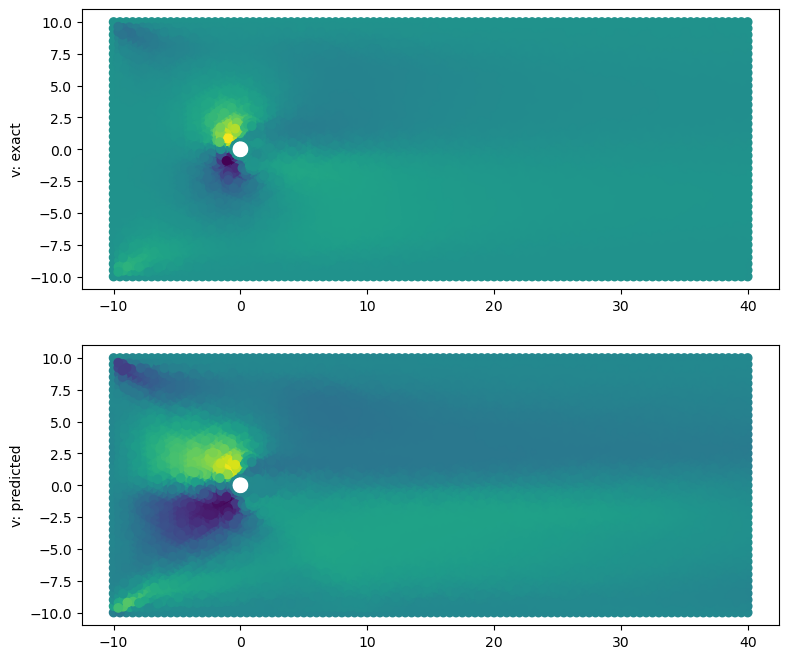

In [185]:
fig = plt.figure(figsize=(9, 8))
ax1 = fig.add_subplot(2,1,1, adjustable='box', )
ax2 = fig.add_subplot(2,1,2)

ax1.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=v_train.cpu()[:74152], cmap="viridis", label="Exact")
ax2.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), c=predicted_v.cpu().detach().numpy(), cmap="viridis", label="Predicted")
ax1.set_ylabel('v: exact')
ax2.set_ylabel('v: predicted')
plt.show()